In [1]:
# ✅ Step 1: Imports and Setup

In [2]:
#cell1
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, confusion_matrix
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment



In [3]:
#cell2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

all_labels = np.array(train_data.targets)
all_images = train_data.data.unsqueeze(1).float() / 255.0






In [4]:
#cell3
class CNNEncoder(nn.Module):
    def __init__(self, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x)



In [5]:
#cell4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = CNNEncoder(embedding_dim=64).to(device)
clf_head = nn.Linear(64, 10).to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(clf_head.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(15):
    total_loss = 0
    encoder.train()
    clf_head.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        feats = encoder(images)
        logits = clf_head(feats)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Classification Loss: {total_loss/len(train_loader):.4f}")





Epoch 1, Classification Loss: 0.4784
Epoch 2, Classification Loss: 0.2945
Epoch 3, Classification Loss: 0.2453
Epoch 4, Classification Loss: 0.2161
Epoch 5, Classification Loss: 0.1890
Epoch 6, Classification Loss: 0.1668
Epoch 7, Classification Loss: 0.1477
Epoch 8, Classification Loss: 0.1295
Epoch 9, Classification Loss: 0.1126
Epoch 10, Classification Loss: 0.0979
Epoch 11, Classification Loss: 0.0855
Epoch 12, Classification Loss: 0.0707
Epoch 13, Classification Loss: 0.0588
Epoch 14, Classification Loss: 0.0519
Epoch 15, Classification Loss: 0.0473


In [6]:
#cell5
encoder.eval()
with torch.no_grad():
    feats = encoder(all_images.to(device)).cpu().numpy()
labels = all_labels


In [7]:
#cell6
class DEC(nn.Module):
    def __init__(self, embedding_dim=64, n_clusters=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_clusters = n_clusters
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, embedding_dim))
        torch.nn.init.xavier_uniform_(self.cluster_centers.data)

    def forward(self, z):
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q ** ((1 + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return z, q



In [8]:
# ✅ Step 2: Load and Subset MNIST Dataset

In [9]:
#cell7
features_tensor = torch.tensor(feats, dtype=torch.float32).to(device)
dec_model = DEC(embedding_dim=64, n_clusters=10).to(device)

kmeans = KMeans(n_clusters=10, n_init=20)
preds_init = kmeans.fit_predict(feats)
dec_model.cluster_centers.data.copy_(
    torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)
)


tensor([[-2.3509e-01, -6.9870e-02,  1.8719e-01, -4.7152e-01, -2.4945e-02,
         -3.8791e-01,  1.9988e-01,  9.3992e-01, -6.2042e-01, -5.5820e-05,
          3.2246e-01, -1.0015e-02, -7.2978e-01,  1.7419e-01,  4.1114e-01,
         -1.4121e+00, -5.4045e-01,  4.2181e-01,  7.5152e-01, -7.9986e-02,
         -1.5456e-01,  3.5417e-01, -6.7466e-01, -4.6106e-01,  6.2252e-02,
         -2.6313e-01,  4.7940e-01, -1.2176e-01,  2.5259e-01, -3.3704e-01,
          3.1060e-01,  3.2289e-01,  7.4559e-01,  2.0667e-01,  3.0668e-01,
          8.5890e-02,  7.5946e-01, -7.8552e-01,  3.6066e-01,  8.7354e-02,
         -4.1908e-01,  1.0753e-01,  3.8469e-01,  4.1869e-01,  4.4410e-01,
          1.2375e-01,  2.0415e-02, -7.6854e-01, -1.9158e-01,  1.2728e-01,
          1.6462e-01,  9.4233e-01, -3.5948e-01,  1.9481e-01, -2.2215e-01,
          3.9030e-01, -4.2516e-01, -6.8887e-01,  4.4950e-01,  1.8706e-01,
         -3.8569e-01,  4.1163e-02,  4.2917e-01, -6.3887e-02],
        [-3.6165e-01,  3.0501e-01,  6.0877e-01,  3

In [10]:
#cell8
def target_distribution(q):
    weight = q ** 2 / torch.sum(q, dim=0)
    return (weight.t() / torch.sum(weight, dim=1)).t()

optimizer = optim.Adam(dec_model.parameters(), lr=1e-3)
criterion = nn.KLDivLoss(reduction='batchmean')

for epoch in range(30):
    dec_model.train()
    _, q = dec_model(features_tensor)
    p = target_distribution(q).detach()
    loss = criterion((q + 1e-10).log(), p)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, KL Loss: {loss.item():.6f}")




Epoch 1, KL Loss: 0.245131
Epoch 2, KL Loss: 0.245178
Epoch 3, KL Loss: 0.245225
Epoch 4, KL Loss: 0.245271
Epoch 5, KL Loss: 0.245316
Epoch 6, KL Loss: 0.245360
Epoch 7, KL Loss: 0.245404
Epoch 8, KL Loss: 0.245447
Epoch 9, KL Loss: 0.245489
Epoch 10, KL Loss: 0.245531
Epoch 11, KL Loss: 0.245571
Epoch 12, KL Loss: 0.245611
Epoch 13, KL Loss: 0.245650
Epoch 14, KL Loss: 0.245688
Epoch 15, KL Loss: 0.245725
Epoch 16, KL Loss: 0.245762
Epoch 17, KL Loss: 0.245797
Epoch 18, KL Loss: 0.245831
Epoch 19, KL Loss: 0.245865
Epoch 20, KL Loss: 0.245897
Epoch 21, KL Loss: 0.245929
Epoch 22, KL Loss: 0.245960
Epoch 23, KL Loss: 0.245990
Epoch 24, KL Loss: 0.246019
Epoch 25, KL Loss: 0.246047
Epoch 26, KL Loss: 0.246075
Epoch 27, KL Loss: 0.246101
Epoch 28, KL Loss: 0.246127
Epoch 29, KL Loss: 0.246152
Epoch 30, KL Loss: 0.246176


In [11]:
#cell9
dec_model.eval()
with torch.no_grad():
    z_final, q_final = dec_model(features_tensor)
    pred_labels = q_final.cpu().numpy().argmax(axis=1)

conf_matrix = confusion_matrix(labels, pred_labels)
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
mapped_preds = np.zeros_like(pred_labels)
for i in range(len(row_ind)):
    mapped_preds[pred_labels == col_ind[i]] = row_ind[i]

accuracy = np.mean(mapped_preds == labels)
print(f"Clustering Accuracy: {accuracy * 100:.2f}%")
print("Silhouette:", silhouette_score(z_final.cpu(), pred_labels))
print("CH Index:", calinski_harabasz_score(z_final.cpu(), pred_labels))
print("DB Index:", davies_bouldin_score(z_final.cpu(), pred_labels))




Clustering Accuracy: 73.96%
Silhouette: 0.2286028
CH Index: 13782.533
DB Index: 1.3355103150475436


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


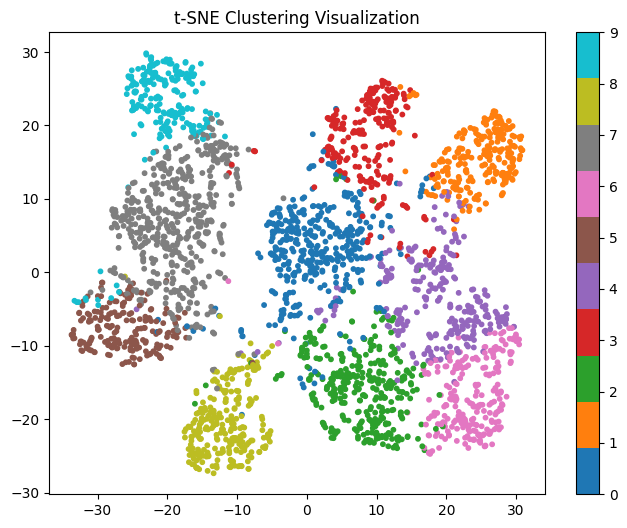

In [12]:
#cell10
sample_indices = np.random.choice(len(z_final), size=3000, replace=False)
z_sample = z_final[sample_indices].cpu().numpy()
label_sample = mapped_preds[sample_indices]

z_tsne = TSNE(n_components=2, n_iter=500, random_state=42).fit_transform(z_sample)
plt.figure(figsize=(8, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=label_sample, cmap='tab10', s=10)
plt.title("t-SNE Clustering Visualization")
plt.colorbar()
plt.show()

